In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

class MorphologicalOperation(Function):
    """
    Custom autograd Function for applying erosion and dilation.
    """
    @staticmethod
    def forward(ctx, input, weight, operation='dilation'):
        # Save for backward pass
        ctx.save_for_backward(input, weight)
        ctx.operation = operation

        # Pad the input to handle borders
        padding = weight.shape[-1] // 2
        input_padded = F.pad(input, (padding, padding, padding, padding), mode='reflect')

        # Perform dilation or erosion
        if operation == 'dilation':
            output = F.max_pool2d(input_padded, kernel_size=weight.shape[-1], stride=1)
        elif operation == 'erosion':
            output = -F.max_pool2d(-input_padded, kernel_size=weight.shape[-1], stride=1)
        else:
            raise ValueError(f"Unsupported operation: {operation}")

        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight = ctx.saved_tensors
        grad_input = grad_weight = None

        # Backward pass logic for the gradients
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.clone()  # Simplified for illustration

        # In a real-world implementation, calculate grad_weight if needed
        return grad_input, grad_weight, None

class MorphologicalLayer(nn.Module):
    """
    A custom morphological layer for erosion and dilation.
    """
    def __init__(self, kernel_size=3, operation='dilation'):
        super(MorphologicalLayer, self).__init__()
        self.operation = operation
        self.kernel_size = kernel_size
        # Initialize a learnable kernel (filter)
        self.weight = nn.Parameter(torch.ones(1, 1, kernel_size, kernel_size), requires_grad=True)

    def forward(self, x):
        return MorphologicalOperation.apply(x, self.weight, self.operation)

In [ ]:
class HybridCNN(nn.Module):
    def __init__(self):
        super(HybridCNN, self).__init__()
        # Morphological layer for feature extraction
        self.morph_layer = MorphologicalLayer(kernel_size=3, operation='dilation')
        # Convolutional layers for further feature extraction
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 1)  # Output for binary classification (e.g., tumor or no tumor)

    def forward(self, x):
        x = self.morph_layer(x)
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)  # Flatten the output
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x

In [ ]:
# Instantiate the model
model = HybridCNN()

# Create a dummy input tensor representing a batch of grayscale images (batch_size=1, channels=1, height=32, width=32)
dummy_input = torch.randn(1, 1, 32, 32)

# Perform a forward pass through the model
output = model(dummy_input)

print(f"Output: {output}")

Output: tensor([[0.5248]], grad_fn=<SigmoidBackward0>)


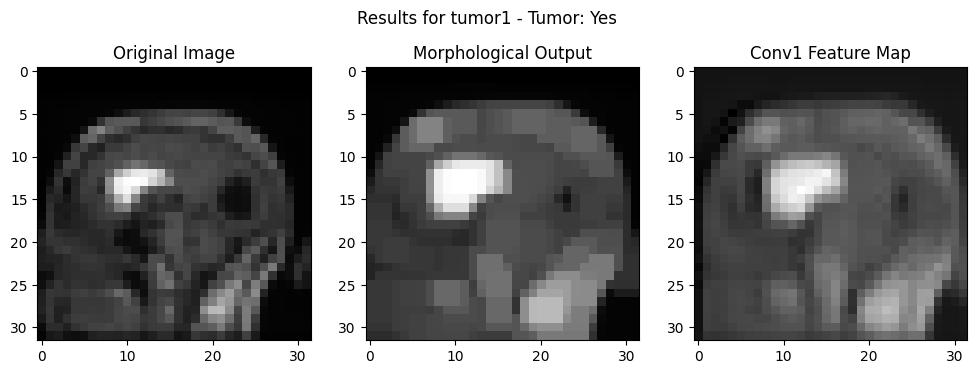

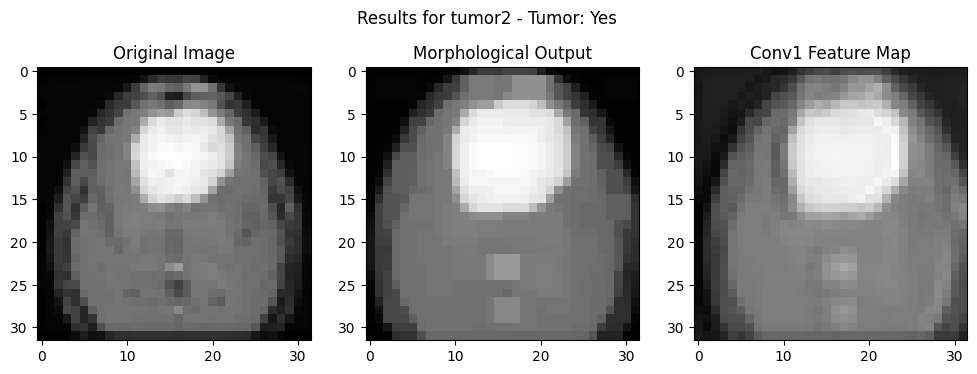

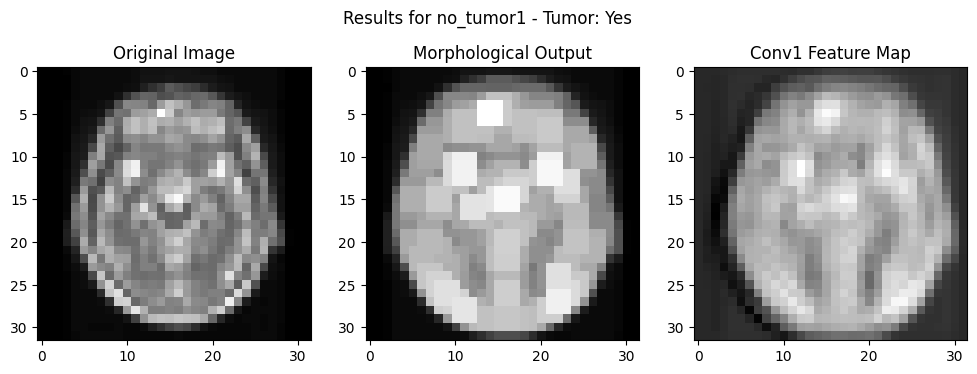

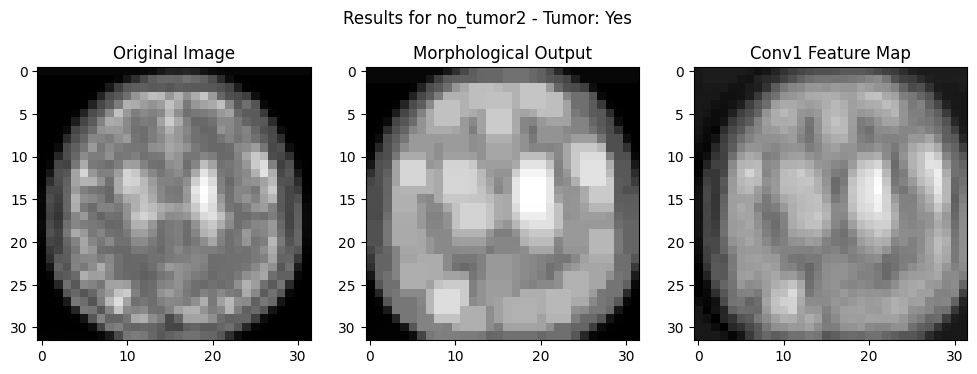

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

# Custom morphological operation class
class MorphologicalOperation(Function):
    @staticmethod
    def forward(ctx, input, weight, operation='dilation'):
        ctx.save_for_backward(input, weight)
        ctx.operation = operation

        padding = weight.shape[-1] // 2
        input_padded = F.pad(input, (padding, padding, padding, padding), mode='reflect')

        if operation == 'dilation':
            output = F.max_pool2d(input_padded, kernel_size=weight.shape[-1], stride=1)
        elif operation == 'erosion':
            output = -F.max_pool2d(-input_padded, kernel_size=weight.shape[-1], stride=1)
        else:
            raise ValueError(f"Unsupported operation: {operation}")

        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, weight = ctx.saved_tensors
        grad_input = grad_weight = None
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.clone()
        return grad_input, grad_weight, None

class MorphologicalLayer(nn.Module):
    def __init__(self, kernel_size=3, operation='dilation'):
        super(MorphologicalLayer, self).__init__()
        self.operation = operation
        self.kernel_size = kernel_size
        self.weight = nn.Parameter(torch.ones(1, 1, kernel_size, kernel_size), requires_grad=True)

    def forward(self, x):
        return MorphologicalOperation.apply(x, self.weight, self.operation)

class HybridCNN(nn.Module):
    def __init__(self):
        super(HybridCNN, self).__init__()
        self.morph_layer = MorphologicalLayer(kernel_size=3, operation='dilation')
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.morph_layer(x)
        morph_output = x.detach().cpu().numpy()

        x = F.relu(self.conv1(x))

        conv1_output = x.detach().cpu().numpy()

        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))

        return x, morph_output, conv1_output

# Load images and pre-process
image_paths = {
    'tumor1': 'image(54).jpg',
    'tumor2': 'image(58).jpg',
    'no_tumor1': 'image(104).jpg',
    'no_tumor2': 'image(18).jpg'
}

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

images = {}
for label, path in image_paths.items():
    img = Image.open(path)
    images[label] = transform(img).unsqueeze(0)  # Add batch dimension

# Instantiate the model
model = HybridCNN()

# Run each image through the model and visualize
for name, img_tensor in images.items():
    output, morph_output, conv1_output = model(img_tensor)

    # Visualize original, morphological, and first convolutional layer feature maps
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Results for {name} - Tumor: {"Yes" if "tumor" in name else "No"}')

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(img_tensor[0, 0].cpu(), cmap='gray')
    plt.title("Original Image")

    # After Morphological Layer
    plt.subplot(1, 3, 2)
    plt.imshow(morph_output[0, 0], cmap='gray')
    plt.title("Morphological Output")

    # After First Convolutional Layer
    plt.subplot(1, 3, 3)
    plt.imshow(conv1_output[0, 0], cmap='gray')
    plt.title("Conv1 Feature Map")

    plt.show()
